# Collabrative Filtering Model 
### Using NN- PyTorch
- Pytorch
    - PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. It is free and open-source software released under the Modified BSD license.
    - Official website
        - https://pytorch.org/
    - Getting started with PyTorch
        - https://pytorch.org/get-started/locally/
    - Pytorch tutorials
        - https://pytorch.org/tutorials/
    - Official Documentation
        - https://pytorch.org/docs/stable/index.html
    
- What is user-item based collaborative filtering?
    - Item based collaborative filtering finds similarity patterns between items and recommends them to users based on the computed information, whilst user based finds similar users and gives them recommendations based on what other people with similar consumption patterns appreciated.


### Installing pytorch on CP4D
`!pip3 install torch`

### Import required modules

In [1]:
#from pathlib import Path
import pandas as pd
import numpy as np
#import random as r
#from IPython.display import Image
#from IPython.core.display import HTML 
%matplotlib inline
import torch
import time
from sklearn import preprocessing
from google.cloud import bigquery


t0 = time.time()
porcentaje = 5
limite = int(189857*porcentaje) # 18,985,770  # corre en mi local %5 del total de la muestra

fecha_corte_train = '2017-11-30'
# functions
def get_data_BQ(sql):
    client = bigquery.Client()
    df = client.query(sql).to_dataframe()
    return(df)

In [2]:
sql = ''' SELECT ID_CTE, ID_FAM, GENERO, EDAD, cast(count(*)  as int64 )  as FRECUENCIA
FROM `rmf2gcp.RawData.Pytorch_trial` 
WHERE ID_CTE <= ''' + str(limite) + '''
AND FECHA_TICKET <= "''' + fecha_corte_train + '''"
AND GENERO is not null 
group by ID_CTE, ID_FAM, GENERO, EDAD
'''
print(sql)

 SELECT ID_CTE, ID_FAM, GENERO, EDAD, cast(count(*)  as int64 )  as FRECUENCIA
FROM `rmf2gcp.RawData.Pytorch_trial` 
WHERE ID_CTE <= 949285
AND FECHA_TICKET <= "2017-11-30"
AND GENERO is not null 
group by ID_CTE, ID_FAM, GENERO, EDAD



### Read and display the data



In [3]:
data = get_data_BQ(sql)
data.head()


,ID_CTE,ID_FAM,GENERO,EDAD,FRECUENCIA
0,599159,105001,M,45,1
1,771020,103239,F,104,1
2,465177,313152,F,83,2
3,111822,703349,F,89,3
4,314504,869214,F,86,2


### Total rows and columns in the dataset

In [4]:
print("Total Rows: {}".format(data.shape[0]))
print("Total Columns: {}".format(data.shape[1]))
print(data.dtypes)
print(data.head(20))

Total Rows: 3605741
Total Columns: 5
ID_CTE         int64
ID_FAM         int64
GENERO        object
EDAD           int64
FRECUENCIA     int64
dtype: object
    ID_CTE  ID_FAM GENERO  EDAD  FRECUENCIA
0   599159  105001      M    45           1
1   771020  103239      F   104           1
2   465177  313152      F    83           2
3   111822  703349      F    89           3
4   314504  869214      F    86           2
5    58963  645020      F    87           1
6   278125  387299      F    92           1
7   382809  210065      M    83           1
8   301368  318073      F    90           1
9   849359  459015      M    83           1
10  709743  860241      F    90           1
11  103867  105244      F    84           5
12   11709  318073      F    82           1
13  444093  229003      F    82           1
14   15183  106002      M    83           1
15  718021  279019      F    85           2
16  530495  106061      M    45           5
17  164145  960001      M    87           1
18  3083

### List of features to be included 

For the model:
- USERID
- ITEMID
- GENGER
- AGE
- __FRECUENCIA__ 


Condideremos luego las otras 
- 'EDO_CIVIL'
- 'D_EDO'

In [5]:
features_to_be_included = ["USERID","ITEMID", "GENDER", "AGE"]
features_to_be_included

['USERID', 'ITEMID', 'GENDER', 'AGE']

In [6]:
#robust_scallar = preprocessing.RobustScaler()
#data[['FRECUENCIA']] = robust_scallar.fit_transform(data[["FRECUENCIA"]]) # no se para que lo hace float !!!!!!!!111
data.dtypes

ID_CTE         int64
ID_FAM         int64
GENERO        object
EDAD           int64
FRECUENCIA     int64
dtype: object

### Renaming the columns

- 'ID_CTE': 'USERID'

- 'ID_FAM1': 'ITEMID'

- 'GENERO':'GENDER'

- 'EDO_CIVIL':'MARITAL_STATUS'

- 'D_EDO':'STATE'

- 'FRECUENCIA':'FREQUENCY'


In [7]:
print("columns before: ",list(data.columns))
data = data.rename(columns={'ID_CTE': 'USERID', 'ID_FAM': 'ITEMID', 'GENERO':'GENDER', 'FRECUENCIA':'FREQUENCY', 'EDAD':'AGE'})
print("columns after: ",list(data.columns))

columns before:  ['ID_CTE', 'ID_FAM', 'GENERO', 'EDAD', 'FRECUENCIA']
columns after:  ['USERID', 'ITEMID', 'GENDER', 'AGE', 'FREQUENCY']


### Describe Frequency column
- min -> 1
- max -> 8
- count -> 3034

In [8]:
data["FREQUENCY"].describe()

count    3.605741e+06
mean     1.433604e+00
std      1.085569e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.260000e+02
Name: FREQUENCY, dtype: float64

### Value counts for the frequency column
- 1 ->  2830

- 2 ->  174

- 3 ->  25

- 5 ->  2

- 4 ->  2

- 8 ->  1

In [9]:
data["FREQUENCY"].value_counts()

1      2724750
2       547909
3       184117
4        72749
5        32991
6        17558
7         9416
8         5538
9         3501
10        2234
11        1435
12         951
13         617
14         485
15         355
16         257
17         169
18         139
19         103
20          81
21          65
22          59
23          46
26          36
25          27
24          26
29          19
28          16
30          10
31           8
27           8
34           8
36           8
32           7
33           6
37           6
35           4
41           2
53           2
46           2
38           2
40           2
39           2
73           1
55           1
64           1
62           1
59           1
82           1
56           1
42           1
54           1
51           1
48           1
47           1
44           1
83           1
126          1
Name: FREQUENCY, dtype: int64

In [10]:
print(data.isnull().sum()) #cuidemos los nulos 
data.GENDER.value_counts()

USERID       0
ITEMID       0
GENDER       0
AGE          0
FREQUENCY    0
dtype: int64


F    2693989
M     911752
Name: GENDER, dtype: int64

## Encoding Gender Column
- M -> 1
- F -> 0

In [11]:
# data["GENDER"] = data["GENDER"].apply(lambda x : -1 if x is None else ( 0 if x == 'M' else  1 ) ) # las F son mayoria
data["GENDER"] = data["GENDER"].apply(lambda x : 0 if x is None else ( 0 if x == 'M' else  1 ) ) # TEST:TODO
data.tail()


,USERID,ITEMID,GENDER,AGE,FREQUENCY
3605736,66256,102011,0,81,1
3605737,632630,702003,0,81,1
3605738,92159,248001,0,81,1
3605739,73212,102012,0,81,1
3605740,374531,229022,1,81,1


## Train and Validate dataset

- Train dataset: `dec16-nov17_Jalisco_with_features.csv`
- Validate dataset: `dec17_Jalisco_with_features.csv`

In [12]:
#renaming data to train dataframe
train = data # aqui no hay problema con la copia es por referencia 

#reading validate dataset
sql = ''' SELECT ID_CTE, ID_FAM, GENERO, EDAD, count(*) as FRECUENCIA
FROM `rmf2gcp.RawData.Pytorch_trial` 
WHERE ID_CTE <= ''' + str(limite) + '''
AND FECHA_TICKET > "''' + fecha_corte_train + '''" 
AND GENERO is not null 
group by ID_CTE, ID_FAM, GENERO, EDAD
'''
print(sql)
val = get_data_BQ(sql)
#robust_scallar = preprocessing.RobustScaler()
#val[['FRECUENCIA']] = robust_scallar.fit_transform(val[["FRECUENCIA"]]) # no se para que lo hace float !!!!!!!!111
#renaming columns

val = val.rename(columns={'ID_CTE': 'USERID', 'ID_FAM': 'ITEMID', 'GENERO':'GENDER', 'FRECUENCIA':'FREQUENCY', 'EDAD':'AGE'})
val.GENDER.value_counts()

 SELECT ID_CTE, ID_FAM, GENERO, EDAD, count(*) as FRECUENCIA
FROM `rmf2gcp.RawData.Pytorch_trial` 
WHERE ID_CTE <= 949285
AND FECHA_TICKET > "2017-11-30" 
AND GENERO is not null 
group by ID_CTE, ID_FAM, GENERO, EDAD



F    175537
M     63194
Name: GENDER, dtype: int64

In [13]:
# val["GENDER"] = val["GENDER"].apply(lambda x : -1 if x is None else ( 0 if x == 'M' else  1 ) ) # las F son mayoria
val["GENDER"] = val["GENDER"].apply(lambda x : 0 if x is None else ( 0 if x == 'M' else  1 ) ) # TEST:TODO

print("Rows in Train dataset: {}".format(train.shape[0]))
print("Columns in Train dataset: {}".format(train.shape[1]))
print("\nRows in validate dataset: {}".format(val.shape[0]))
print("Columns in validate dataset: {}".format(val.shape[1]))

print("\nValidation dataset: ")
val.head()

Rows in Train dataset: 3605741
Columns in Train dataset: 5

Rows in validate dataset: 238731
Columns in validate dataset: 5

Validation dataset: 


,USERID,ITEMID,GENDER,AGE,FREQUENCY
0,45673,594389,0,92,1
1,639769,248001,0,83,1
2,599168,869213,0,44,1
3,397766,862009,0,82,1
4,793439,104115,1,82,1


## Converting column to continues values
- Collabrative Filtering:
    - All the features are representied in series of weights.
    - It is necessary to convert the data values to continues values
        - Each continuos value can be given series of weights

#### proc_col (process column)
- Method that takes inputlist/series and converts its to continous values
- Returns 
    - dictionary(mapping of name -> index)
    - list of index 
    - length of the total values 

Example:
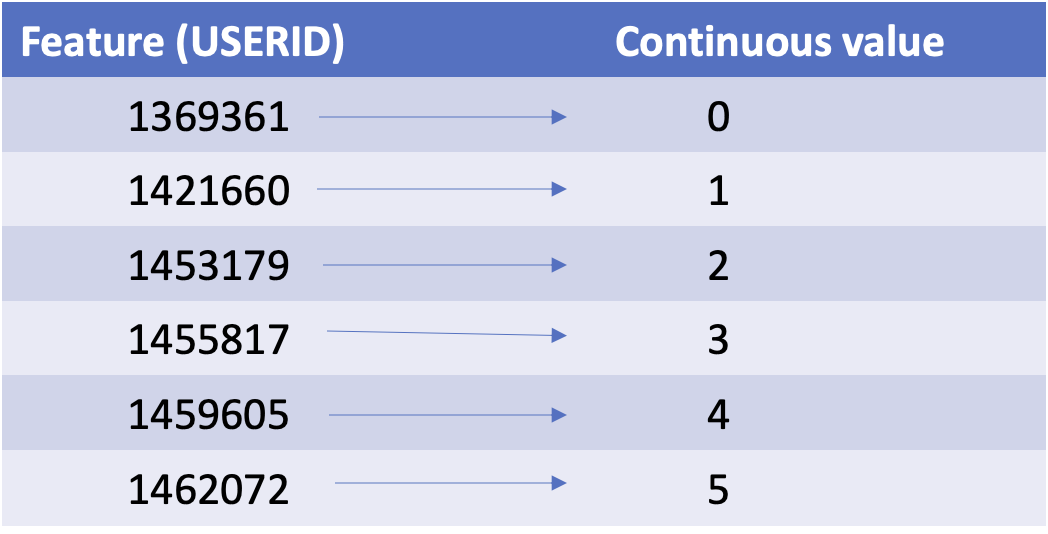

- Returns:
    - `{ 1369361: 0, 1421660: 1, 1453179: 2, 1455817: 3, 1459605: 4, 1462072: 5,}` 
    - `\[0, 1, 2, 3, 4, 5\]`
    - `6`

In [14]:
def proc_col(col, train_col=None):
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)


#### encode_data
- Takes data frame as input and returns dataframe with data converted into continous values

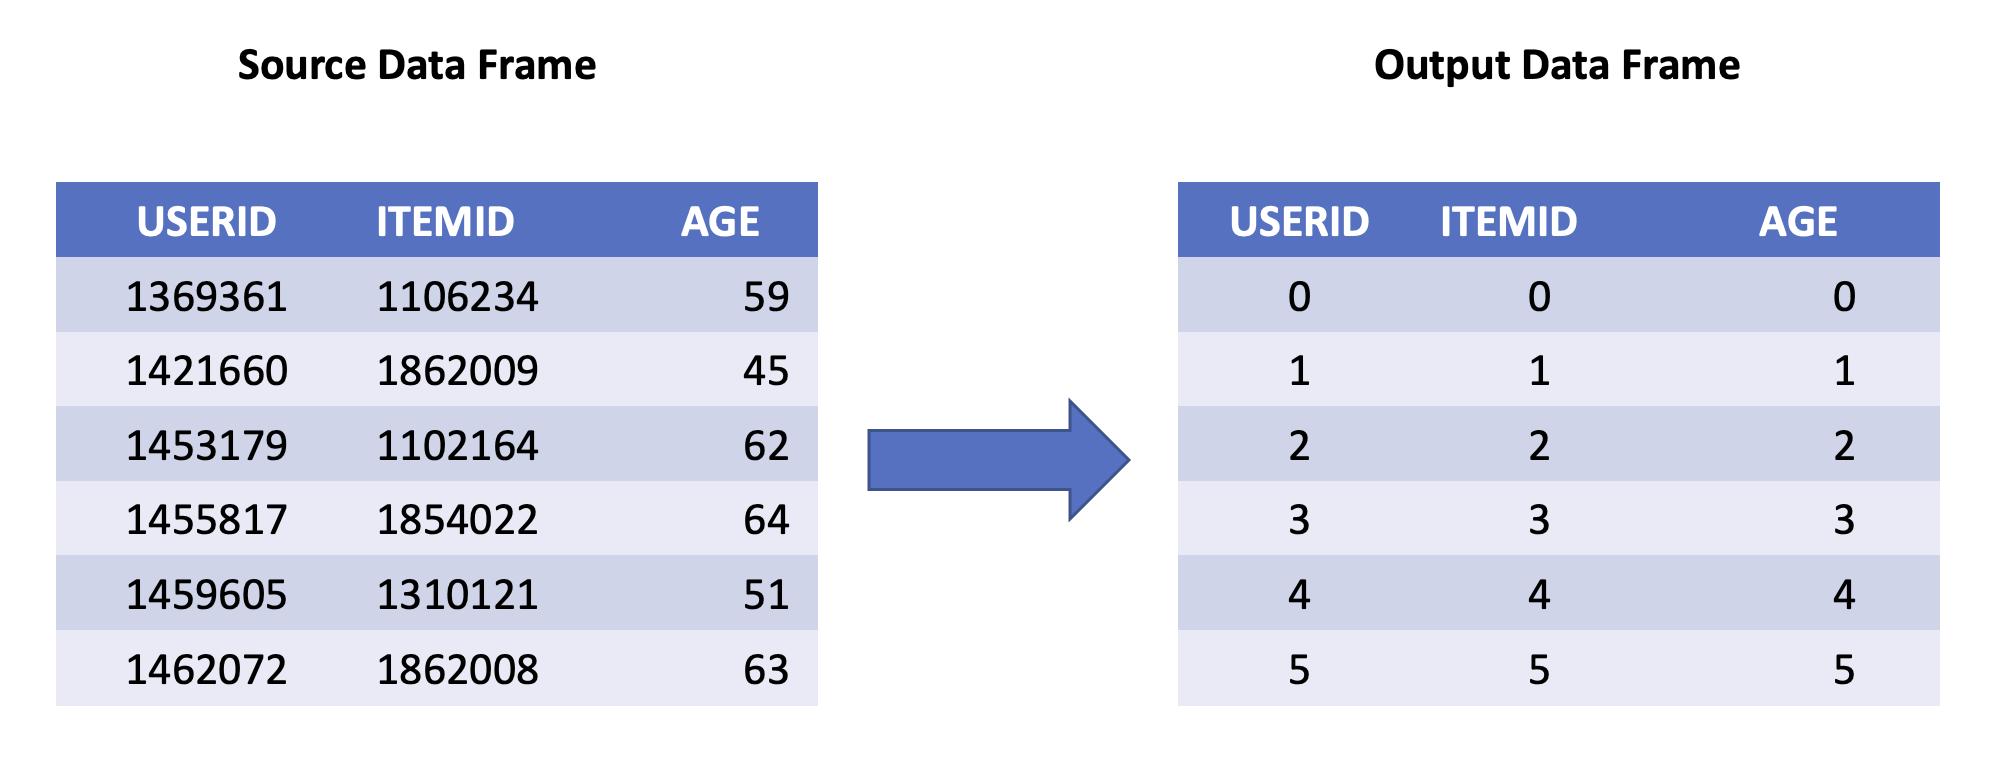



In [15]:
# POR QUE LES GUSTA HACER ESTO A MANO ?? SI YA SE PUEDE HACER EN PANDAS SIN ROLLO 
def encode_data(df, train=None):
    """ Encodes rating data with continous userid's,movie ids and gender. 
    If train is provided, encodes df with the same encoding as train.
    USERID	ITEMID	FRECUENCIA
    """
    encode_featues = ["USERID", "ITEMID", "AGE"]
    df = df.copy()
    mapping = {}
    for col_name in encode_featues:
        train_col = None
        if train is not None:
            train_col = train[col_name] 
        mapper,col,_ = proc_col(df[col_name], train_col)
        mapping[col_name] = mapper
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df,mapping

In [16]:
[ (key,value) for key, value in proc_col(data["USERID"])[0].items() ][0:10]

[(599159, 0),
 (771020, 1),
 (465177, 2),
 (111822, 3),
 (314504, 4),
 (58963, 5),
 (278125, 6),
 (382809, 7),
 (301368, 8),
 (849359, 9)]

In [17]:
[ (key,value) for key, value in proc_col(data["ITEMID"])[0].items() ][0:10]

[(105001, 0),
 (103239, 1),
 (313152, 2),
 (703349, 3),
 (869214, 4),
 (645020, 5),
 (387299, 6),
 (210065, 7),
 (318073, 8),
 (459015, 9)]

In [18]:
[ (key,value) for key, value in proc_col(data["GENDER"])[0].items() ][0:10]

[(0, 0), (1, 1)]

In [19]:
[ (key,value) for key, value in proc_col(data["AGE"])[0].items() ][0:10]

[(45, 0),
 (104, 1),
 (83, 2),
 (89, 3),
 (86, 4),
 (87, 5),
 (92, 6),
 (90, 7),
 (84, 8),
 (82, 9)]

### Encoding train and validate datasets

In [20]:
print("Train dataset before encoding:")
train.head()

Train dataset before encoding:


,USERID,ITEMID,GENDER,AGE,FREQUENCY
0,599159,105001,0,45,1
1,771020,103239,1,104,1
2,465177,313152,1,83,2
3,111822,703349,1,89,3
4,314504,869214,1,86,2


In [21]:
#encoding train dataset
df_train, train_mapping = encode_data(train)

#encoding on validate dataset
df_val, validate_mapping = encode_data(val, train)

print("shape of train: ",df_train.shape)
print("shape of train: ",df_val.shape)


shape of train:  (3605741, 5)
shape of train:  (234714, 5)


In [22]:
print("Train dataset after encoding:")
df_train.head()

Train dataset after encoding:


,USERID,ITEMID,GENDER,AGE,FREQUENCY
0,0,0,0,0,1
1,1,1,1,1,1
2,2,2,1,2,2
3,3,3,1,3,3
4,4,4,1,4,2


## Mapping encoded data back to actual dataset

In [23]:
print("Actual Userids from raw files: ", list(train_mapping["USERID"].keys())[:5])
print("Original_userid->encoded_userid")
for k in list(train_mapping["USERID"].keys())[:5]:
    print("{}->{}".format(k,train_mapping["USERID"][k]))

Actual Userids from raw files:  [599159, 771020, 465177, 111822, 314504]
Original_userid->encoded_userid
599159->0
771020->1
465177->2
111822->3
314504->4


In [24]:
print("Actual Itemids from raw files: ", list(train_mapping["ITEMID"].keys())[:5])
print("Original_itemid->encoded_itemid")
for k in list(train_mapping["ITEMID"].keys())[:5]:
    print("{}->{}".format(k,train_mapping["ITEMID"][k]))

Actual Itemids from raw files:  [105001, 103239, 313152, 703349, 869214]
Original_itemid->encoded_itemid
105001->0
103239->1
313152->2
703349->3
869214->4


## Collabrative Filtering Model
- Each Feature is converted into set of weights
- All the weights for different features are feed as input to the neural net

### Embedding Features 
# __aqui la palabra clave es el embedding__ !!!


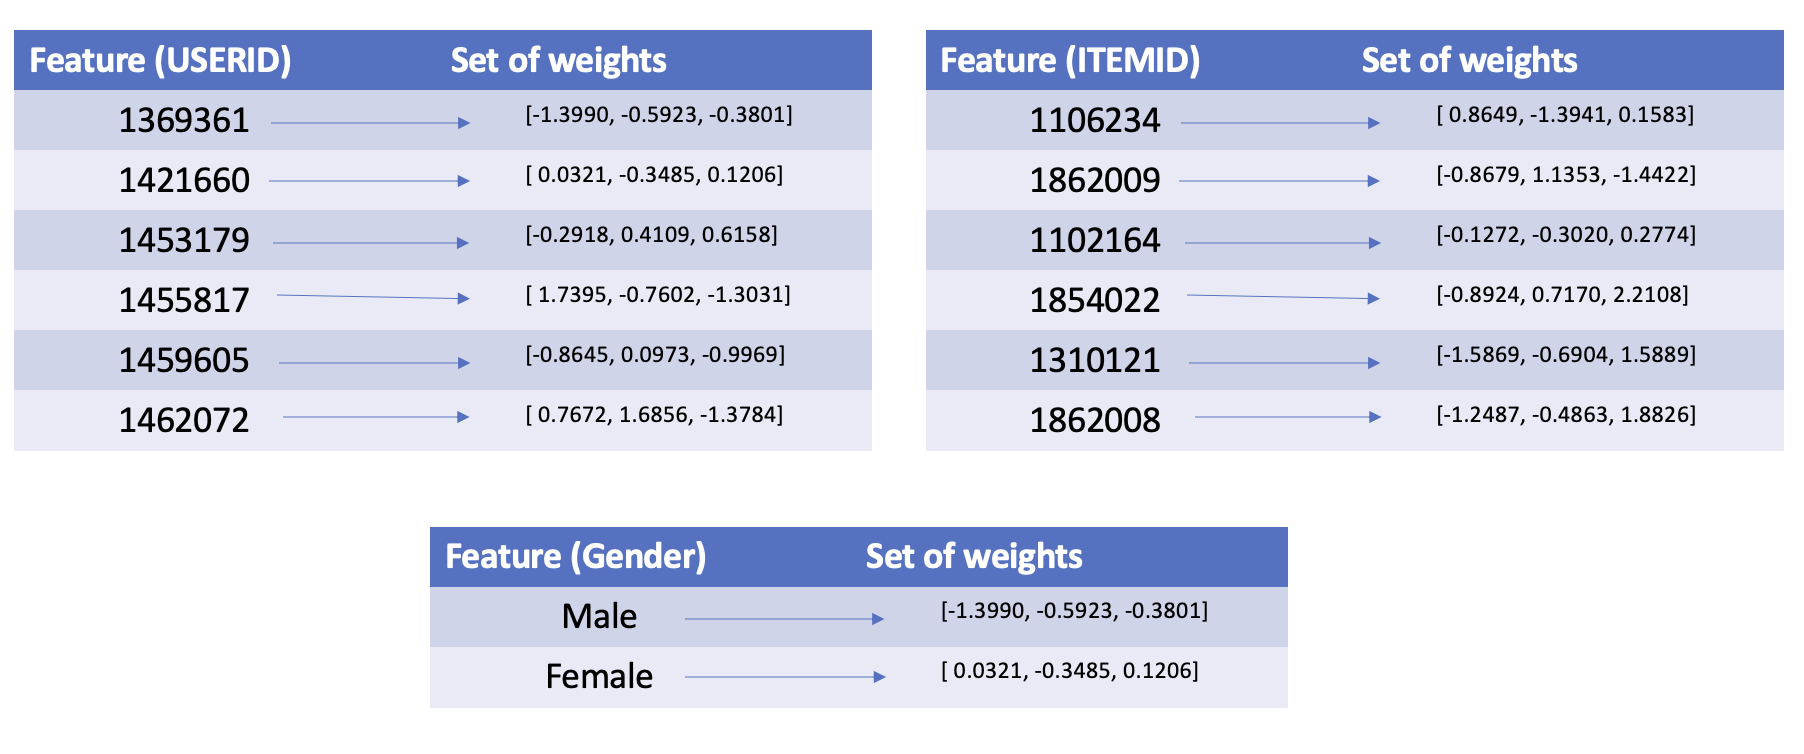

### Input to Neural Network

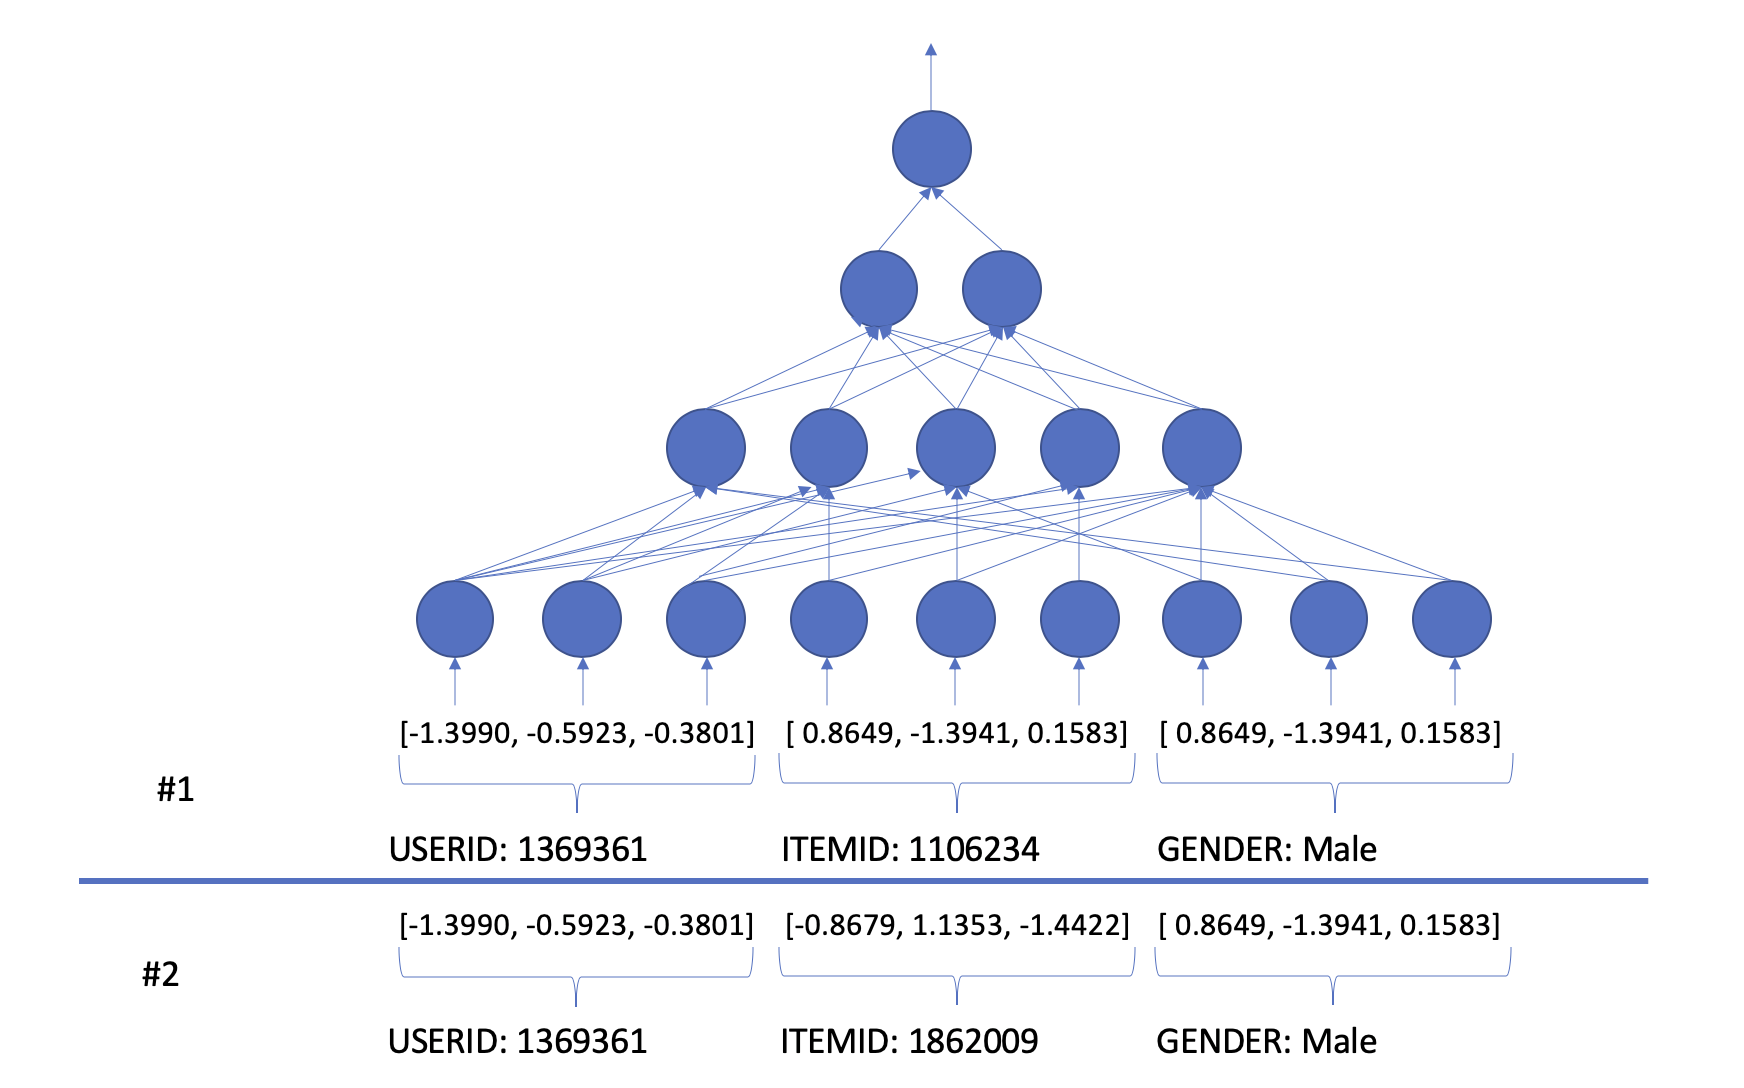

### Importing torch libraries

In [25]:
#import torch
import torch.nn as nn
import torch.nn.functional as F

## Embedding using Pyrtorch
- A simple lookup table that stores embeddings of a fixed dictionary and size.
- Example:

<code>
>>> # an Embedding module containing 10 tensors of size 3
>>> embedding = nn.Embedding(10, 3)
>>> # a batch of 2 samples of 4 indices each
>>> input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
>>> embedding(input)
tensor([[[-0.0251, -1.6902,  0.7172],
         [-0.6431,  0.0748,  0.6969],
         [ 1.4970,  1.3448, -0.9685],
         [-0.3677, -2.7265, -0.1685]],
</code><code>
         [[ 1.4970,  1.3448, -0.9685],
         [ 0.4362, -0.4004,  0.9400],
         [-0.6431,  0.0748,  0.6969],
         [ 0.9124, -2.3616,  1.1151]]])
</code>

- Documentation:
    - https://pytorch.org/docs/master/generated/torch.nn.Embedding.html

### Creating a NN model called CollabFNet
    - Building Collabrative Filtering model
    
    params:
        
        num_users - Count of users
        num_items - Count of Items
        num_gender - Count of gender
        num_age - Count of age
        
        n_hidden1 - Hidden Layer1 size (DEFAULT-10)
        n_hidden2 - Hidden Layer2 size (DEFAULT-10)
        
### Why do we need dropouts
    - A Simple Way to Prevent Neural Networks from Overfitting.
    - A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data.
    - Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
    
    More about droupouts:
    
        - https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5
        
        - https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/#:~:text=%E2%80%94%20Dropout%3A%20A%20Simple%20Way%20to%20Prevent%20Neural%20Networks%20from%20Overfitting,be%20required%20when%20using%20dropout.
        
        
### 7 Commonly used activation functions in NN
https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/

In [26]:
class CollabFNet(nn.Module):
    def __init__(self,num_users, num_items, num_gender, num_age, emb_size,n_hidden1=10,n_hidden2=10 ):
        """
        This is the Collabrative Filtering model which primarily does the below:
        - Created the emdedding weigths for each feature for the given emb_size
        - Builds NN for with 3 layers
        - At each layer drop out of 30% is been added
        
        Size of the first layer:
            (emb_size) * (Count of Features)
            
        params:
        
        num_users - Count of users
        num_items - Count of Items
        num_gender - Count of gender
        num_age - Count of age
        
        n_hidden1 - Hidden Layer2 size (DEFAULT-10)
        n_hidden2 - Hidden Layer3 size (DEFAULT-10)
        
        
        """
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.gender_emb = nn.Embedding(num_gender, emb_size)
        self.age_emb = nn.Embedding(num_age, emb_size)
        
        self.layer1 = nn.Linear(emb_size*4, n_hidden1)#number of features=4
        self.layer2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer3 = nn.Linear(n_hidden2, 1)
        
        self.drop1 = nn.Dropout(0.3) #https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        self.drop2 = nn.Dropout(0.3)
        self.drop3 = nn.Dropout(0.3)
        
    def forward(self, user, item, gender, age ): 
        U = self.user_emb(user)
        I = self.item_emb(item)
        G = self.item_emb(gender)
        A = self.item_emb(age)
        
        x = F.relu(torch.cat([U,I,G,A], dim=1)) # relu activation function
        
        x = self.drop1(x)
        x = F.relu(self.layer1(x))
        
        x = self.drop2(x)
        x = F.relu(self.layer2(x))
        
        x = self.drop3(x)
        x = self.layer3(x)
        
        return x

### Converting data to tensors

In [27]:
#for test dataset
data_train_with_values = {val:torch.LongTensor(df_train[val].values) for val in features_to_be_included}
frequency_train = {"FREQUENCY": torch.FloatTensor(df_train.FREQUENCY.values)}

#for validate dataset
data_validate_with_values = {val:torch.LongTensor(df_val[val].values) for val in features_to_be_included}
ratings_validate = torch.FloatTensor(df_val.FREQUENCY.values) #.cuda()
val.head()

,USERID,ITEMID,GENDER,AGE,FREQUENCY
0,45673,594389,0,92,1
1,639769,248001,0,83,1
2,599168,869213,0,44,1
3,397766,862009,0,82,1
4,793439,104115,1,82,1


### Train epochs
- train_epocs_generic
    params:
        model: model object on which training is performed
        data_train_with_values: training dataset
            type: Dict
                    Key: column name (Feature Name)
                    Value: torch tensor
        frequency_train:
            type: Dict
                    Key: Frequency
                    Value: torch tensor  
        epochs: Total number of epochs (DEFAULT: 10)
        lr: Learning rate (DEFAULT: 0.01)
        wd: Weight_decay (DEFAULT: 0.0)

- What is Optimizer ?
    - Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses
    - Optimization algorithms or strategies are responsible for reducing the losses and to provide the most accurate results possible
    - https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3
    
    
- Why do we need Loss funcction ?
    - Loss is nothing but a prediction error of Neural Net. And the method to calculate the loss is called Loss Function.
    - https://towardsdatascience.com/understanding-different-loss-functions-for-neural-networks-dd1ed0274718

In [28]:
train_loss = []
def train_epocs_generic(model,data_train_with_values,frequency_train, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    """
    params:
        model: model object on which training is performed
        data_train_with_values: training dataset
            type: Dict
                    Key: column name (Feature Name)
                    Value: torch tensor
        frequency_train:
            type: Dict
                    Key: Frequency
                    Value: torch tensor  
        epochs: Total number of epochs (DEFAULT: 10)
        lr: Learning rate (DEFAULT: 0.01)
        wd: Weight_decay (DEFAULT: 0.0)
    """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    #Adaptive Moment Estimation (Adam)
    
    #changing model to train mode
    model.train()
    
    for i in range(epochs):
        ratings = frequency_train["FREQUENCY"]
        
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
            
        y_hat = model(data_train_with_values["USERID"],
                      data_train_with_values["ITEMID"],
                      data_train_with_values["GENDER"],
                      data_train_with_values["AGE"])
        
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("epoch "+str(i)+" train loss %.3f " % loss.item(),end =" ")
        train_loss.append(loss.item())
        test_loss_generic(model,data_validate_with_values,ratings_validate,unsqueeze)

### Test loss
- test_loss_generic
    - params:
        model : model object on which testing is performed
        data_validate_with_values: test dataset
            type: Dict
                    Key: column name (Feature Name)
                    Value: torch tensor
        ratings:
            type: Dict
                    Key: Frequency
                    Value: torch tensor 

In [29]:
test_loss = []
def test_loss_generic(model,data_validate_with_values,ratings,unsqueeze=False):
    """
    params:
        model : model object on which testing is performed
        data_validate_with_values: test dataset
            type: Dict
                    Key: column name (Feature Name)
                    Value: torch tensor
        ratings:
            type: Dict
                    Key: Frequency
                    Value: torch tensor 
    """
    #changing model to evaluate mode
    model.eval()
    
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
        
    y_hat = model(data_validate_with_values["USERID"],
                  data_validate_with_values["ITEMID"],
                  data_validate_with_values["GENDER"], 
                  data_validate_with_values["AGE"], )
    
    loss = F.mse_loss(y_hat, ratings)
    
    print(" test loss %.3f " % loss.item())
    test_loss.append(loss.item())

Building dicctionary called features_num with total count of:
    - USERID
    - ITEMID
    - GENDER
    - AGE

In [30]:
features_num = { key: len(df_train[key].unique()) for key in features_to_be_included}
num_users = len(df_train.USERID.unique())
num_items = len(df_train.ITEMID.unique())
print(features_num)

{'USERID': 187943, 'ITEMID': 2209, 'GENDER': 2, 'AGE': 88}


In [31]:
hyper_parameters={"num_users": features_num["USERID"],
                 "num_items": features_num["ITEMID"],
                 "num_age": features_num["AGE"],
                 "num_gender": features_num["GENDER"],
                 "emb_size": 10,
                 "n_hidden1":10,
                 "n_hidden2":5}

model_generic = CollabFNet(**hyper_parameters) 


In [ ]:
#weight decay - When training neural networks, it is common to use "weight decay," where after each update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large, and can be seen as gradient descent on a quadratic regularization term.

train_epocs_generic(model_generic,data_train_with_values,frequency_train, epochs=40, lr=0.05, wd=1e-6, unsqueeze=True)


epoch 0 train loss 4.165   test loss 1.039 
epoch 1 train loss 2.336   test loss 1.003 
epoch 2 train loss 1.624   test loss 1.091 
epoch 3 train loss 1.653   test loss 0.422 
epoch 4 train loss 1.260   test loss 0.405 
epoch 5 train loss 1.405   test loss 0.423 
epoch 6 train loss 1.444   test loss 0.362 
epoch 7 train loss 1.304   test loss 0.378 
epoch 8 train loss 1.174   test loss 0.593 
epoch 9 train loss 1.227   test loss 0.737 
epoch 10 train loss 1.298   test loss 0.590 
epoch 11 train loss 1.205   test loss 0.411 
epoch 12 train loss 1.134   test loss 0.344 
epoch 13 train loss 1.158   test loss 0.338 
epoch 14 train loss 1.192   test loss 0.336 
epoch 15 train loss 1.179   test loss 0.341 
epoch 16 train loss 1.130   test loss 0.390 
epoch 17 train loss 1.092   test loss 0.489 
epoch 18 train loss 1.101   test loss 0.565 
epoch 19 train loss 1.122   test loss 0.540 
epoch 20 train loss 1.104   test loss 0.454 
epoch 21 train loss 1.069   test loss 0.384 


In [ ]:
print(len(train_loss))
print(len(test_loss))

In [ ]:
import seaborn as sns
start_temp = 0
r = list(range(0,len(train_loss[start_temp:])))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,9))
plt.plot(r,train_loss[start_temp:], label="train- loss")
plt.plot(r,test_loss[start_temp:], label="val-loss")
plt.legend()

## Predictions


In [ ]:
model_generic.eval()
val_pred = model_generic(data_validate_with_values["USERID"],
                      data_validate_with_values["ITEMID"],
                      data_validate_with_values["GENDER"],
                      data_validate_with_values["AGE"])
loss = F.mse_loss(val_pred, ratings_validate)
# loss

val_pred = val_pred.detach().squeeze().numpy()
print(val_pred.shape)
pred_df = pd.DataFrame({"USERID":data_validate_with_values["USERID"].numpy(),
                   "ITEMID": data_validate_with_values["ITEMID"].numpy(),
                   "GENDER":data_validate_with_values["GENDER"].numpy(),
                   "AGE":data_validate_with_values["AGE"].numpy(),
                   "PREDICT":val_pred})#"PRED":y_hat.detach().numpy()
# print(px["P"].value_counts())
# pred_df[pred_df["PREDICT"] >= 1.5]
pred_df.head(10)

In [ ]:
validate_mapping_users = { validate_mapping["USERID"][k]: k for k in validate_mapping["USERID"]}
validate_mapping_items = { validate_mapping["ITEMID"][k]: k for k in validate_mapping["ITEMID"]}
validate_mapping_age = { validate_mapping["AGE"][k]: k for k in validate_mapping["AGE"]}

pred_df["USERID"] = pred_df["USERID"].apply(lambda x: validate_mapping_users.get(x,-1))
pred_df["ITEMID"] = pred_df["ITEMID"].apply(lambda x: validate_mapping_items.get(x,-1))
pred_df["AGE"] = pred_df["AGE"].apply(lambda x: validate_mapping_age.get(x,-1))

pred_df.head(100)

In [ ]:
torch.save(model_generic.state_dict(), "model_save")

In [ ]:
model_generic

In [ ]:
torch.cuda.is_available()

### Additional help
- Good and free course to get started with pytorch
    - https://www.udacity.com/course/deep-learning-pytorch--ud188

- DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ
    - https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
    
- LEARNING PYTORCH WITH EXAMPLES
    - https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
    
- Tunning neural networks
    - https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b

In [ ]:
pred_df.shape

In [ ]:
val.shape

In [ ]:
val.shape[0] - pred_df.shape[0]

In [ ]:
pred_df.head(10)

In [ ]:
print(pred_df.USERID.value_counts())

In [ ]:
print(pred_df.ITEMID.value_counts())

In [ ]:
pred_df.head(10)

In [ ]:
val.head(10)

In [ ]:
val = pred_df.merge(val, how='outer')

# __notas la diferencia en los que sí se predicen y los que no, es porque no estan en la muestra original ESTO DA PIE A SIMULAR TODOS LOS POSIBLES ESCENARIOS INCLUYENDO RECOMENDACIONES PARA CLIENTES QUE COMPRAN EN EFECTIVO :D__ 

In [ ]:
val.plot.scatter(x = 'FREQUENCY', y='PREDICT', c='purple')

In [ ]:
table_id = 'Resultados.test_pytorch_0'+str(porcentaje)+'porciento_17_junio_2020'
val.to_gbq(table_id, project_id='rmf2gcp')
t3 = time.time()
total = t3-t0
print(total)